## Ομάδα #75 
### Νικόλαος Μανιάτης - Φίλιππος Μαυρεπής

##### Datasets: S12,	B04,	119

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns

**Dataset Abstract**
NASA data set, obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel.

**Attribute Information:**

This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels.

In [2]:
features = ['freq','angle','length','velocity','thickness','pressure']
df = pd.read_table('./datasets/airfoil_self_noise.dat',names = features )
print(df.shape)
df.head()

(1503, 6)


,freq,angle,length,velocity,thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [3]:
df.isna().sum()

freq         0
angle        0
length       0
velocity     0
thickness    0
pressure     0
dtype: int64

In [4]:
df.corr()

,freq,angle,length,velocity,thickness,pressure
freq,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
angle,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
thickness,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
pressure,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


In [5]:
df.columns

Index(['freq', 'angle', 'length', 'velocity', 'thickness', 'pressure'], dtype='object')

### Variance Inflation Factor

In [6]:
# VIF dataframe 
vif_data = df.copy()
vif_data = vif_data.drop(['pressure'],axis=1)
# calculating VIF for each feature 
x = [variance_inflation_factor(vif_data.values, i) 
                          for i in range(len(vif_data.columns))] 
  
x

[1.942626754570521,
 6.557489390964023,
 3.2544472087129463,
 7.148723394340731,
 4.299617241817294]

### Train-Test-Split our Dataset

In [4]:
from sklearn.model_selection import train_test_split

In [8]:
X = df.copy()
X = X.drop(['pressure'],axis=1)
y = df[['pressure']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=75)
print('X train shape:',X_train.shape)
print('X test shape:',X_test.shape)
print('y train shape:',y_train.shape)
print('y test shape:',y_test.shape)

X train shape: (1052, 5)
X test shape: (451, 5)
y train shape: (1052, 1)
y test shape: (451, 1)


## Ordinary Least Squares ΣΟΥΛΟΥΠΩΜΑ ΕΔΩ, ΝΑ ΣΥΖΗΤΗΣΟΥΜΕ ΤΙ ΦΕΥΓΕΙ ΚΑΙ ΤΙ ΟΧΙ

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
reg = LinearRegression().fit(X_train, y_train)

In [12]:
reg.score(X_test, y_test)

0.48701529018157896

#### Recursive Feature Elimination

In [13]:
from sklearn.feature_selection import RFE

In [14]:
selector = RFE(reg, n_features_to_select=4, step=1,verbose=2)
selector = selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

Fitting estimator with 5 features.
[False  True  True  True  True]
[2 1 1 1 1]


## Polynomial Regression ΑΥΤΌ ΤΟ ΑΦΗΣΑΜΕ ΠΙΟ ΚΑΤΩ (?)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [16]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)

array([[1.00000000e+00, 8.00000000e+02, 0.00000000e+00, ...,
        5.08369000e+03, 1.89898281e-01, 7.09353976e-06],
       [1.00000000e+00, 1.00000000e+03, 0.00000000e+00, ...,
        5.08369000e+03, 1.89898281e-01, 7.09353976e-06],
       [1.00000000e+00, 1.25000000e+03, 0.00000000e+00, ...,
        5.08369000e+03, 1.89898281e-01, 7.09353976e-06],
       ...,
       [1.00000000e+00, 4.00000000e+03, 1.56000000e+01, ...,
        1.56816000e+03, 2.09280852e+00, 2.79298509e-03],
       [1.00000000e+00, 5.00000000e+03, 1.56000000e+01, ...,
        1.56816000e+03, 2.09280852e+00, 2.79298509e-03],
       [1.00000000e+00, 6.30000000e+03, 1.56000000e+01, ...,
        1.56816000e+03, 2.09280852e+00, 2.79298509e-03]])

In [17]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
...                   ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
model = model.fit(X_train,y_train)
model.named_steps['linear'].coef_
model.score(X_test, y_test)

0.6223336446282257

In [18]:
for i in range(1,4):
    model = Pipeline([('poly', PolynomialFeatures(degree=i)),
    ('linear', LinearRegression(fit_intercept=False))])
    # fit to an order-3 polynomial data
    model = model.fit(X_train,y_train)
    model.named_steps['linear'].coef_
    print('degree of polynomial = {} and score is {}'.format(i,model.score(X_test, y_test)))

degree of polynomial = 1 and score is 0.48701529018065426
degree of polynomial = 2 and score is 0.6223336446282257
degree of polynomial = 3 and score is 0.7209720262016102


In [5]:
features = ['freq','angle','length','velocity','thickness','pressure']
df = pd.read_table('./datasets/airfoil_self_noise.dat',names = features )
print(df.shape)
df.head()

(1503, 6)


,freq,angle,length,velocity,thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [6]:
X = df.copy()
X = X.drop(['pressure'],axis=1)
y = df[['pressure']]

In [7]:
from sklearn import preprocessing
scaler_x = preprocessing.MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = preprocessing.MinMaxScaler()
y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1,1))
y_scaled = y_scaled.reshape(-1)
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y_scaled, random_state=1)
# val_y = scaler_y.inverse_transform(np.array(val_y).reshape(-1,1))

In [8]:
models = []
models.append(('LR', LinearRegression()))
models.append(('RD', Ridge()))
models.append(('LAS', Lasso()))
models.append(('DT', DecisionTreeRegressor(random_state=75)))
models.append(('MLP', MLPRegressor(random_state=75)))#Default Hidden Layers
models.append(('DMLP'), MLPRegressor(random_state=75, hidden_layer_sizes=(100,100)))#With 1 extra hidden layer, default is (100,). (Deep Multi Layer Perceptron).
models.append(('SVR',SVR()))
models.append(('ET',ExtraTreesRegressor(random_state=75)))
models.append(('XGB', XGBRegressor(random_state=75)))

In [12]:
def compare_models(trainX,trainY,testX,testY,models):
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    
    names = []
    tempdf = pd.DataFrame(columns=['Name','Dataset','Score','St.Dev'])
    for name, model in models:
        model.fit(trainX,trainY)
        kfold = KFold(n_splits=2,shuffle=True,random_state = 75)
        train_accuracy_results = cross_val_score(model, trainX,trainY, cv=kfold)
        test_accuracy_results = cross_val_score(model,testX,testY,cv=kfold)
        tempdf = tempdf.append({'Name':name,'Dataset':'Train','Score':train_accuracy_results.mean(),
                               'St.Dev':train_accuracy_results.std()},ignore_index=True)
        tempdf = tempdf.append({'Name':name,'Dataset':'Test','Score':test_accuracy_results.mean(),
                               'St.Dev':test_accuracy_results.std()},ignore_index=True)
    print(tempdf) 
    g = sns.catplot(x = 'Name', y='Score',hue = 'Dataset',data=tempdf, kind='bar')
    g.set_xticklabels(rotation=30)
    plt.show()    
    return tempdf


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

   Name Dataset         Score        St.Dev
0    LR   Train  5.220069e-01  1.386776e-02
1    LR    Test  4.134636e-01  5.838136e-03
2    RD   Train  5.223920e-01  9.644159e-03
3    RD    Test  4.058728e-01  2.520266e-02
4   LAS   Train -4.150551e-09  7.837497e-11
5   LAS    Test -2.704928e-02  4.787929e-03
6    DT   Train  7.602865e-01  4.976846e-03
7    DT    Test  4.679349e-01  8.720270e-02
8   MLP   Train  6.025453e-01  7.498945e-03
9   MLP    Test  1.481680e-01  1.235114e-01
10  SVR   Train  7.145073e-01  1.904287e-02
11  SVR    Test  5.754953e-01  3.654529e-04
12   ET   Train  8.949353e-01  1.938535e-02
13   ET    Test  7.270670e-01  2.649790e-02
14  XGB   Train  8.924899e-01  5.571336e-03
15  XGB    Test  7.490595e-01  2.314538e-02


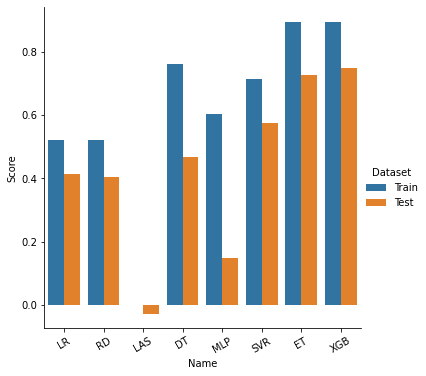

In [13]:
models_df = compare_models(train_X, train_y, test_X, test_y, models)

About LASSO:
It's not impossible to get an R^2 value less than 0.
R^2 is a metric used to measure the performance of a regressor. The optimal score of R^2 metric is 1. If any regressor predicts a constant value, you should expect an R^2 score of 0 for that regressor. **But unexpectedly, you can get worse performance than that.**

## Optimization for each regressor individually

In [84]:
models_opt = []

#### 1. Linear Regression: Has to hyperparameters to optimize.

In [85]:
LR = LinearRegression()
models_opt.append(('LD*',LR))

#### 2. Ridge Regression

In [86]:
%%time
Ridge_ = GridSearchCV(Ridge(), param_grid = {'alpha':[i for i in np.arange(0,1,0.05)],\
                                                'solver':('svd', 'cholesky', 'lsqr')},cv=KFold(n_splits=2,shuffle=True,random_state = 75))
Ridge_.fit(train_X,train_y)

Wall time: 246 ms


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.0, 0.05, 0.1, 0.15000000000000002, 0.2,
                                   0.25, 0.30000000000000004,
                                   0.35000000000000003, 0.4, 0.45, 0.5, 0.55,
                                   0.6000000000000001, 0.65, 0.7000000000000001,
                                   0.75, 0.8, 0.8500000000000001, 0.9,
                                   0.9500000000000001],
                         'solver': ('svd', 'cholesky', 'lsqr')})

In [87]:
Ridge_.best_estimator_

Ridge(alpha=0.55, solver='lsqr')

In [88]:
Ridge_opt = Ridge(alpha=0.55, solver = 'lsqr')
Ridge_opt.fit(train_X,train_y)

Ridge(alpha=0.55, solver='lsqr')

In [89]:
models_opt.append(('RD*',Ridge_opt))

#### 3. Lasso Regression

In [90]:
%%time
Lasso_ = GridSearchCV(Lasso(), param_grid = {'alpha':[0.0001, 0.0002,0.001,0.01,0.1,0.2,0.5,0.8,1],\
                                            'max_iter':[k for k in np.arange(1000,10000,500)],
                                            'tol':[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]},cv=KFold(n_splits=2,shuffle=True,random_state = 75))
Lasso_.fit(train_X,train_y)

Wall time: 2.7 s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.001, 0.01, 0.1, 0.2, 0.5,
                                   0.8, 1],
                         'max_iter': [1000, 1500, 2000, 2500, 3000, 3500, 4000,
                                      4500, 5000, 5500, 6000, 6500, 7000, 7500,
                                      8000, 8500, 9000, 9500],
                         'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                 1e-08]})

In [91]:
Lasso_.best_estimator_

Lasso(alpha=0.0002, tol=0.01)

In [93]:
Lasso_opt = Lasso(alpha=0.0002,tol=0.01)
Lasso_opt.fit(train_X,train_y)

Lasso(alpha=0.0002, tol=0.01)

In [94]:
models_opt.append(('LAS*',Lasso_opt))

Παρατηρούμε ότι στις περιπτώσεις Ridge&Lasso Regression το γεγονός ότι $\alpha\rightarrow 0$, σημαίνει ότι το πρόβλημά μας τείνει σε αυτό της απλής γραμμικής παλινδρόμησης επομένως παίρνουμε τους ίδιους συντελεστές με αυτό, γιαυτό και οι 2 τιμές του $R^2$ συγκλίνουν προς αυτό της γραμμικής παλινδρόμησης.

#### 4. Decision Trees Regressor

In [95]:
%%time
DT_ = GridSearchCV(DecisionTreeRegressor(), param_grid = {'criterion': ['mse', 'mae'],
                                                          'max_depth': [None,1,2,3,4,5,6,7,8,9,10],
                                                         "min_samples_split":range(2,10),
                                                         "min_samples_leaf":range(1,5)}
                                                          ,n_jobs = -1,cv=KFold(n_splits=2,shuffle=True,random_state = 75))
DT_.fit(train_X, train_y)

Wall time: 1.34 s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10)})

In [96]:
DT_.best_estimator_

DecisionTreeRegressor(criterion='mae')

In [97]:
DT_opt = DecisionTreeRegressor(criterion='mae')
DT_opt.fit(train_X,train_y)

DecisionTreeRegressor(criterion='mae')

In [98]:
models_opt.append(('DT*',DT_opt))

**Σημείωση: καθαρίζουμε τις φακές και τις ξεπλε.........οκ εδώ απλά κάνει overfitting.**

**5(a). Multi Layer Perceptron Regressor (no-hidden layers)**

In [75]:
%%time
MLP_ = GridSearchCV(MLPRegressor(random_state=75), param_grid={'activation' : ['tanh','relu'],
                                                'solver':['sgd','adam'],
                                                'alpha':[1e-5,1e-4,1e-3],
                                                'learning_rate':['constant','adaptive'],
                                                'max_iter':[100,200,1000],
                                                'learning_rate_init':[0.0001,0.001,0.003,0.005,0.01]},
                                                 n_jobs = -1,cv=KFold(n_splits=2,shuffle=True,random_state = 75))
MLP_.fit(train_X,train_y)

Wall time: 33.9 s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=MLPRegressor(random_state=75), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [1e-05, 0.0001, 0.001],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.0001, 0.001, 0.003, 0.005,
                                                0.01],
                         'max_iter': [100, 200, 1000],
                         'solver': ['sgd', 'adam']})

In [99]:
MLP_.best_estimator_

MLPRegressor(learning_rate_init=0.01, max_iter=100, random_state=75)

In [77]:
MLP_opt = MLPRegressor(random_state=75, max_iter=100,learning_rate_init=0.01)
MLP_opt.fit(train_X,train_y)#, alpha=1e-02, learning_rate_init=0.003, max_iter=100

MLPRegressor(learning_rate_init=0.01, max_iter=100, random_state=75)

In [100]:
models_opt.append(('MLP*',MLP_opt))


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

   Name Dataset     Score    St.Dev
0   LD*   Train  0.522007  0.013868
1   LD*    Test  0.413464  0.005838
2   RD*   Train  0.522796  0.011365
3   RD*    Test  0.414904  0.017363
4  LAS*   Train  0.522140  0.013903
5  LAS*    Test  0.414883  0.009615
6   DT*   Train  0.798497  0.008425
7   DT*    Test  0.466647  0.104153
8  MLP*   Train  0.617452  0.004457
9  MLP*    Test  0.417174  0.014035


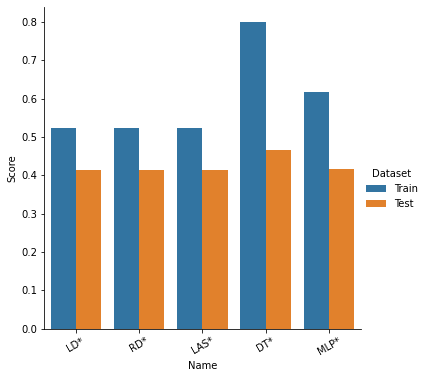

In [101]:
compare_models(train_X,train_y,test_X,test_y,models_opt)

**5(b). Multi Layer Perceptron (with hidden layers)**

Εδώ κρατάμε τις βέλτιστες υπερπαραμέτρους που βρέθηκαν από το παραπάνω Grid Search και τις χρησιμοποιούμε για να κάνουμε κι'άλλο Grid Search, αυτή τη φορά μαζί με hidden layers.

In [102]:
%%time
MLP_2 = GridSearchCV(MLPRegressor(random_state=75), 
                                 param_grid={'max_iter':[100,200,1000],'learning_rate_init':[0.0001,0.001,0.005],
                                'hidden_layer_sizes':[(256, 256, 256),(512,256,128),(64,32,8)]},n_jobs = -1,
                                    cv=KFold(n_splits=2,shuffle=True,random_state = 75))
MLP_2.fit(train_X,train_y)

Wall time: 34.4 s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=MLPRegressor(random_state=75), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(256, 256, 256),
                                                (512, 256, 128), (64, 32, 8)],
                         'learning_rate_init': [0.0001, 0.001, 0.005],
                         'max_iter': [100, 200, 1000]})

Υπενθύμιση μην το ξεχάσουμε: Το hidden_layer_size = (256, 256, 256) έβγαλε το καλύτερο score, ~86.7 \%.

In [103]:
MLP_2.best_estimator_

MLPRegressor(hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.005,
             max_iter=100, random_state=75)

In [104]:
MLP_2_opt = MLPRegressor(hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.005,
             max_iter=100, random_state=75)
MLP_2_opt.fit(train_X,train_y)

MLPRegressor(hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.005,
             max_iter=100, random_state=75)

In [106]:
models_opt.append(('MLP2*',MLP_2_opt))


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

     Name Dataset     Score    St.Dev
0     LD*   Train  0.522007  0.013868
1     LD*    Test  0.413464  0.005838
2     RD*   Train  0.522796  0.011365
3     RD*    Test  0.414904  0.017363
4    LAS*   Train  0.522140  0.013903
5    LAS*    Test  0.414883  0.009615
6     DT*   Train  0.795010  0.006588
7     DT*    Test  0.517652  0.077633
8    MLP*   Train  0.617452  0.004457
9    MLP*    Test  0.417174  0.014035
10  MLP2*   Train  0.835268  0.023792
11  MLP2*    Test  0.578987  0.004919


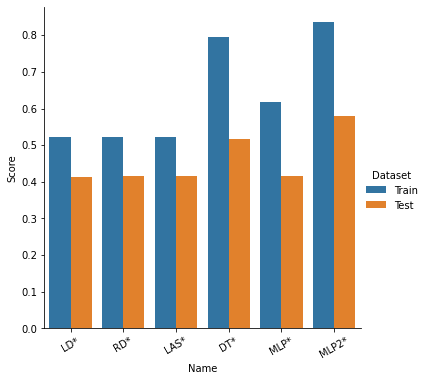

In [107]:
compare_models(train_X,train_y,test_X,test_y,models_opt)

**6. Support Vector Regression  (να το δούμε αυτό μπας και γίνει τίποτα)** 

In [ ]:
%%time
param = {'kernel' : ('linear', 'poly', 'rbf'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}
SVR_ = GridSearchCV(SVR(),param_grid = param,cv = KFold(n_splits=2,shuffle=True,random_state = 75),n_jobs=-1)
SVR_.fit(train_X,train_y)

In [ ]:
SVR_.best_estimator_

In [ ]:
SVR_opt = SVR()
SVR_opt.fit(train_X,train_y)

In [ ]:
models_opt.append(('SVR*',SVR_opt))

**7. Extra Trees Regressor**

In [61]:
%%time
ET_ = GridSearchCV(ExtraTreesRegressor(random_state=75), param_grid = {'criterion': ['mse', 'mae'],
                                                          'max_depth': range(1,15),
                                                         "min_samples_split":range(2,10),
                                                         "min_samples_leaf":range(1,5)},
                                                           n_jobs = -1,cv=5)
ET_.fit(train_X, train_y)

Wall time: 13min 9s


GridSearchCV(cv=10, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(1, 15),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10)})

In [87]:
ET_.best_estimator_

In [ ]:
ET_opt = ExtraTreesRegressor('best params here ')
ET_opt.fit(train_X,train_y)

In [ ]:
models_opt.append(('ET*',ET_opt))

**8. XG Boost Regressor**

In [106]:
%%time
XGB_ = GridSearchCV(XGBRegressor(random_state=75,n_jobs=-1),
                                                            param_grid  = {'min_child_weight':[1,5], 
                                                            'gamma':[i/10.0 for i in range(3,6)],  
                                                            'subsample':[i/10.0 for i in range(6,11)],
                                                            'colsample_bytree':[i/10.0 for i in range(0,5)], 
                                                            'max_depth': [5,6,7],
                                                             'n_estimators':[100,500,1000]},
                                                            n_jobs=-1,cv=10)
XGB_.fit(train_X, train_y)

Wall time: 33min 15s


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs...
                                    num_parallel_tree=None, random_state=75,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_paramete

In [105]:
XGB_.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=75,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
XGB_opt = XGBRegressor('best params here ^^ ')

In [ ]:
models_opt.append(('XGB*',XGB_opt))


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LD*: 0.521027 (0.112379)
RD*: 0.521074 (0.111340)
LAS*: 0.521033 (0.111738)
DT*: 0.822833 (0.039514)
MLP*: 0.645071 (0.113880)
MLP2*: 0.851448 (0.048052)
ET*: 0.938214 (0.014201)
XGB*: 0.764351 (0.057012)


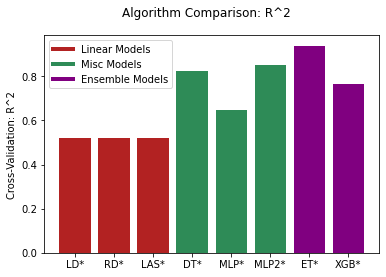

In [108]:
compare_models(train_X, train_y, test_X, test_y, models_opt)

In [ ]:
def compare_models_final(trainX,trainY,testX,testY,models,modelsopt,tempdf):
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    
#     tempdf = pd.DataFrame(columns=['Name','Dataset','Score','St.Dev'])
    for name, model, _,model1 in zip(models,modelsopt):
        model1.fit(trainX,trainY)
        kfold = KFold(n_splits=2,shuffle=True,random_state = 75)
        train_accuracy_results = cross_val_score(model1, trainX,trainY, cv=kfold)
        test_accuracy_results = cross_val_score(model1,testX,testY,cv=kfold)
        tempdf = tempdf.append({'Name':name,'Dataset':'Train*','Score':train_accuracy_results.mean(),
                               'St.Dev':train_accuracy_results.std()},ignore_index=True)
        tempdf = tempdf.append({'Name':name,'Dataset':'Test*','Score':test_accuracy_results.mean(),
                               'St.Dev':test_accuracy_results.std()},ignore_index=True)
    print(tempdf) 
    g = sns.catplot(x = 'Name', y='Score',hue = 'Dataset',data=tempdf, kind='bar')
    g.set_xticklabels(rotation=30)
    plt.show()    
    return

In [15]:
models

[('LR', LinearRegression()),
 ('RD', Ridge()),
 ('LAS', Lasso()),
 ('DT', DecisionTreeRegressor(random_state=75)),
 ('MLP', MLPRegressor(random_state=75)),
 ('SVR', SVR()),
 ('ET', ExtraTreesRegressor(random_state=75)),
 ('XGB',
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=75,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None))]